In [35]:
import pyfits
from scipy.ndimage import gaussian_filter
import scipy.optimize as opt
import numpy as np
import pylab as plt
import rydlab
import pandas as pd
from fitting2d import Fit2d2Gaussian
import os
import copy
from lmfit import Model
from lmfit.models import LorentzianModel
from lmfit.models import ExponentialModel
from lmfit.models import ConstantModel

pd.options.display.max_colwidth = 120

import seaborn as sns
sns.set_style("darkgrid")
import matplotlib as mpl
mpl.rc('image', cmap='afmhot')

file_date = '2019-06-05'
# file_date = '2019-07-03'
# path = 'A:/Projekte - Projects/2019_IEI/July/01'
path= 'A:/Projekte - Projects/2019_SSFI/20190703_48S'
folders = rydlab.analyze_folder(path,filter=False) 
slicer = (slice(10,110),slice(10,410))
binning_scale = 1
folders


Name  \
0                             A:/Projekte - Projects/2019_SSFI/20190703_48S\01_ScanBlueResonance   
1             A:/Projekte - Projects/2019_SSFI/20190703_48S\01_ScanBlueResonance_averaged_images   
2                  A:/Projekte - Projects/2019_SSFI/20190703_48S\02_Scanblueresonant_FieldZeroOn   
3  A:/Projekte - Projects/2019_SSFI/20190703_48S\02_Scanblueresonant_FieldZeroOn_averaged_images   

   Valid  
0   True  
1  False  
2   True  
3  False

In [36]:
path=folders.Name[3]

os.chdir(path)

variables = np.loadtxt( '2019-06-05_variables.dat' )[:,1]
N = len(variables)
print(os.getcwd())

def fitsopen(n,bg):
    if n<10:
        hdulist = pyfits.open(file_date+str("_")+str(0)+str(n)+'.fts')
    else:
        hdulist = pyfits.open(file_date+str("_")+str(n)+'.fts')

    data=np.zeros((90,400))

    for y in range(10,100):
        for x in range(10,410):
            data[y-10,x-10]=-np.log((hdulist[0].data[0,y,x]-hdulist[0].data[2,y,x])/(hdulist[0].data[1,y,x]-hdulist[0].data[2,y,x]))

    hdulist.close()
    return gaussian_filter(data-bg, 1, order=0, output=None, mode='constant', cval=0.0, truncate=4.0)

def fitsopen_bg(n,bg):
    hdulist = pyfits.open(file_date+str("_")+str(n).zfill(2)+'.fts')
    images = hdulist[0].data
    no_absorb = images[0]
    absorb = images[1]
    div = (no_absorb-bg)/(absorb-bg)
    
    div = div[slicer]
    div = -np.log(div)
    div = np.nan_to_num(div)
    return div

def twoD_Gaussian(xy_mesh, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xy_mesh
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)
                        + c*((y-yo)**2)))
    return g.flatten()


def two_Gaussian(xy_mesh, amplitude1, xo1, yo1, sigma_x1, sigma_y1, theta1, amplitude2, xo2, yo2, sigma_x2, sigma_y2, theta2, offset):
    (x, y) = xy_mesh
    xo1 = float(xo1)
    yo1 = float(yo1)
    xo2 = float(xo2)
    yo2 = float(yo2)

    a1 = (np.cos(theta1)**2)/(2*sigma_x1**2) + (np.sin(theta1)**2)/(2*sigma_y1**2)
    b1 = -(np.sin(2*theta1))/(4*sigma_x1**2) + (np.sin(2*theta1))/(4*sigma_y1**2)
    c1 = (np.sin(theta1)**2)/(2*sigma_x1**2) + (np.cos(theta1)**2)/(2*sigma_y1**2)
    a2 = (np.cos(theta2)**2)/(2*sigma_x2**2) + (np.sin(theta2)**2)/(2*sigma_y2**2)
    b2 = -(np.sin(2*theta2))/(4*sigma_x2**2) + (np.sin(2*theta2))/(4*sigma_y2**2)
    c2 = (np.sin(theta2)**2)/(2*sigma_x2**2) + (np.cos(theta2)**2)/(2*sigma_y2**2)

    g = offset + amplitude1*np.exp( - (a1*((x-xo1)**2) + 2*b1*(x-xo1)*(y-yo1) + c1*((y-yo1)**2))) + amplitude2*np.exp( - (a2*((x-xo2)**2) + 2*b2*(x-xo2)*(y-yo2) + c2*((y-yo2)**2)))

    return g.flatten()


def make_background(N):
    list_bg=list()
    for n in range(0,N):
        hdulist = pyfits.open(file_date+str("_")+str(n).zfill(2)+'.fts')
        list_bg.append(hdulist[0].data[2])
        hdulist.close()
    bg_mean = np.array(list_bg).mean(axis=0)
    bg_std = np.array(list_bg).std(axis=0)
    return bg_mean,bg_std
        

def lorentz(x_array,gamma,xoo,a,o):
    xoo = float(xoo)
    gamma = float(gamma)
    x=x_array
    #print(x)
    #print(type(x))
    #l=gamma/((2*np.pi)((x-xoo)**2 + (gamma/2)**2))
    l=a*gamma/( (x-xoo)**2 + (gamma/2)**2 )+o
    #print(l)
    #print(type(l))
    return l#/(2*np.pi)



model_twoG = Model(two_Gaussian)
from lmfit import Parameters
params = Parameters()

params = model_twoG.make_params()

# cloud distribution
params.add('amplitude1',value=0.0)
params.add('yo1',value=160*binning_scale,min=140*binning_scale,max=180*binning_scale)
params.add('xo1',value=45*binning_scale,min=30*binning_scale,max=60*binning_scale)
params.add('sigma_x1',value=5*binning_scale,min=30*binning_scale,max=200*binning_scale)
params.add('sigma_y1',value=5*binning_scale,min=30*binning_scale,max=200*binning_scale)
params.add('theta1',value=0,min=0,max=np.pi)

# EIT/Autler-Townes-dip
params.add('amplitude2',value=0.00)
params.add('yo2',value=171.2*binning_scale,min=168*binning_scale,max=175*binning_scale)
params.add('xo2',value=48.1*binning_scale,min=46*binning_scale,max=50*binning_scale)
params.add('sigma_x2',value=10*binning_scale,min=3*binning_scale,max=15*binning_scale)
#params.add('sigma_y2',value=10,min=3,max=15)
params.add('sigma_y2',expr='sigma_x2')
params.add('theta2',value=0,min=0,max=np.pi)

# offset
params.add('offset',value=0)
bg_mean,bg_std = make_background(N)

model=model_twoG

A:\Projekte - Projects\2019_SSFI\20190703_48S\02_Scanblueresonant_FieldZeroOn_averaged_images


C:\Users\Control_Computer\AppData\Local\conda\conda\envs\rydlab\lib\site-packages\pyfits\util.py:899: UserWarning:

Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.



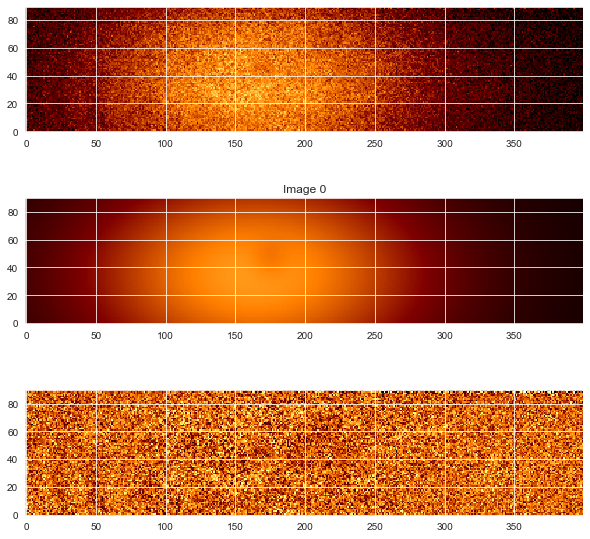

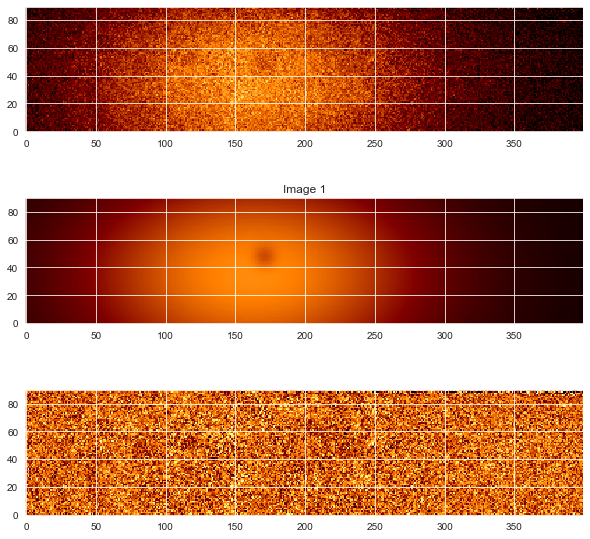

C:\Users\Control_Computer\AppData\Local\conda\conda\envs\rydlab\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning:

divide by zero encountered in true_divide



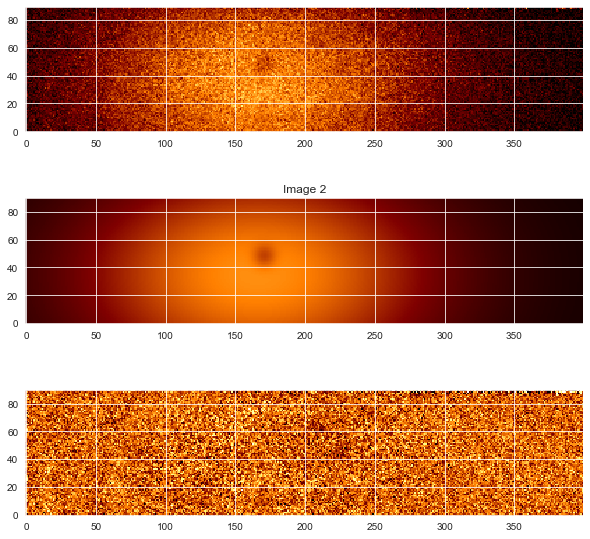

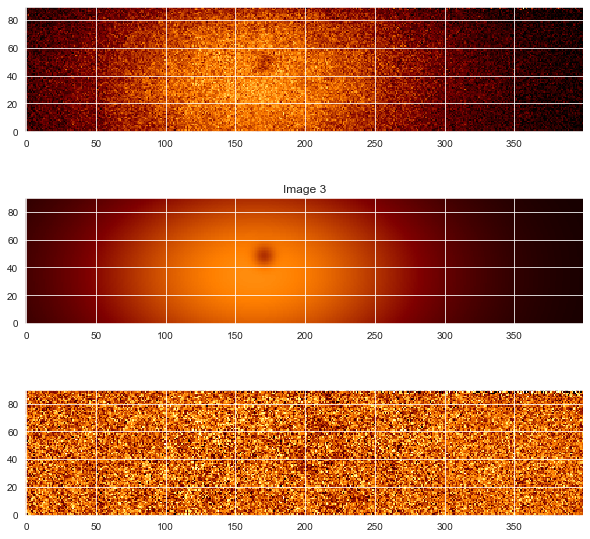

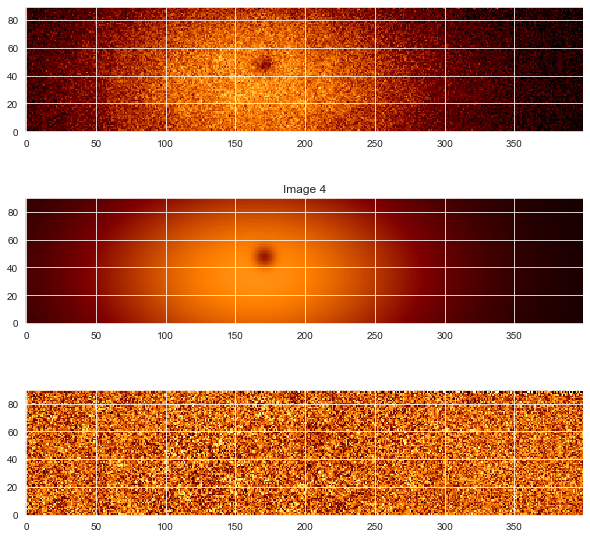

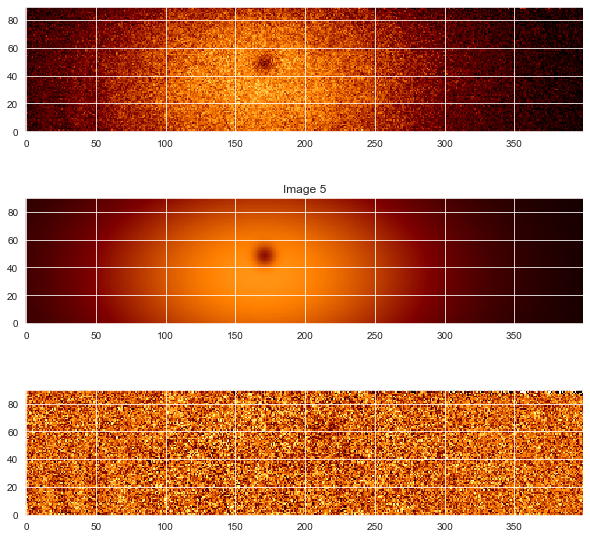

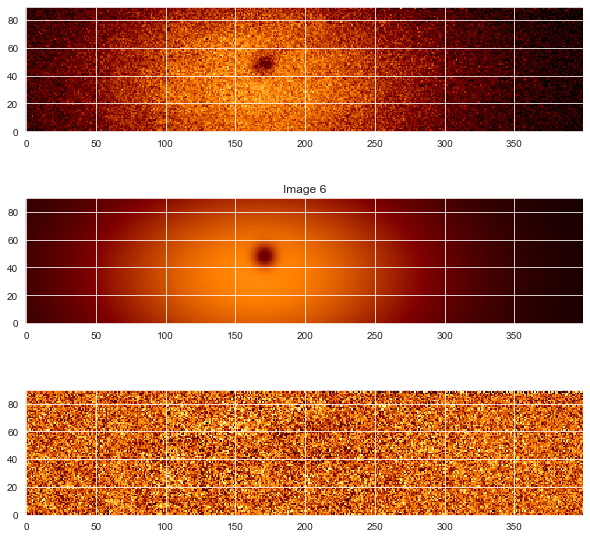

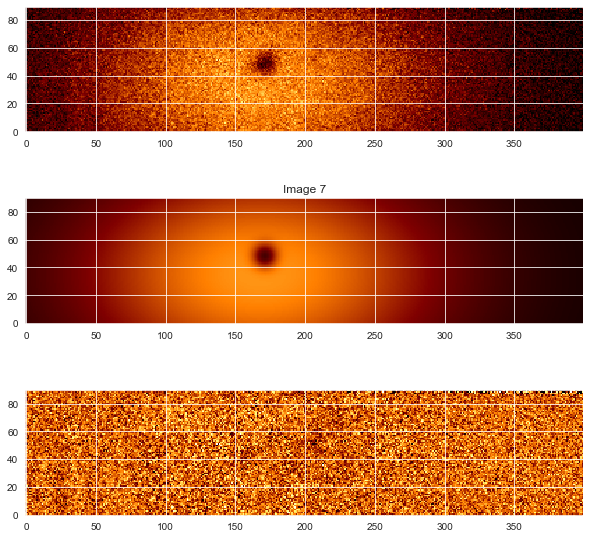

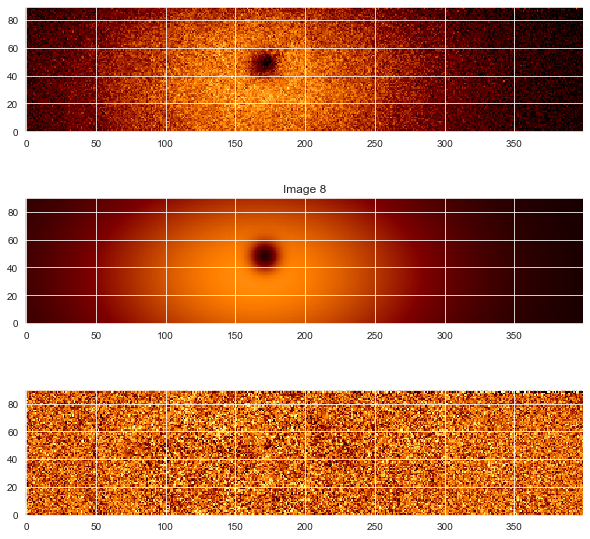

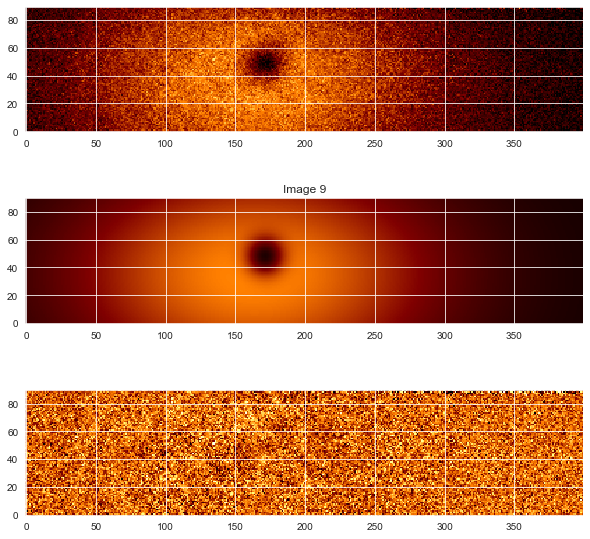

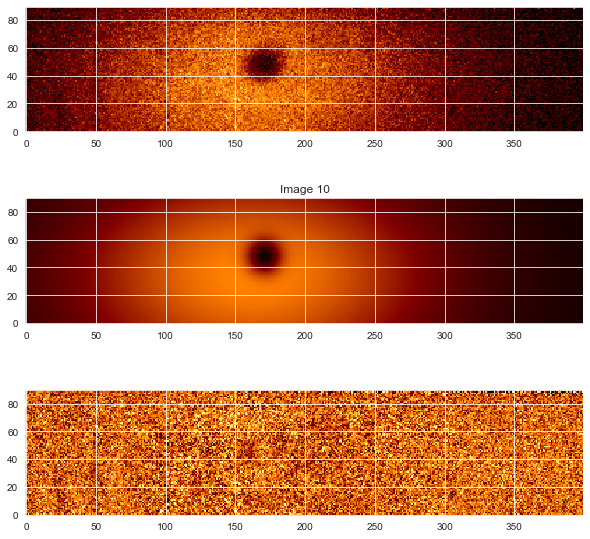

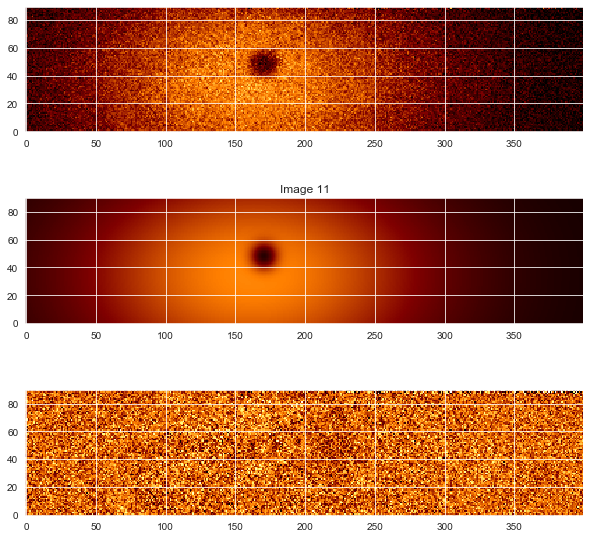

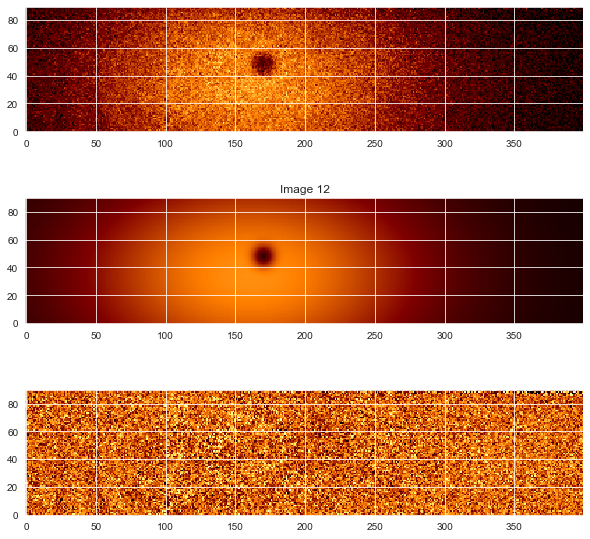

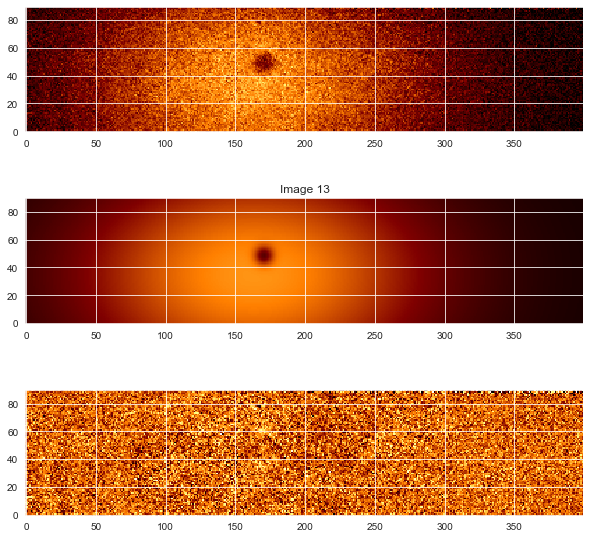

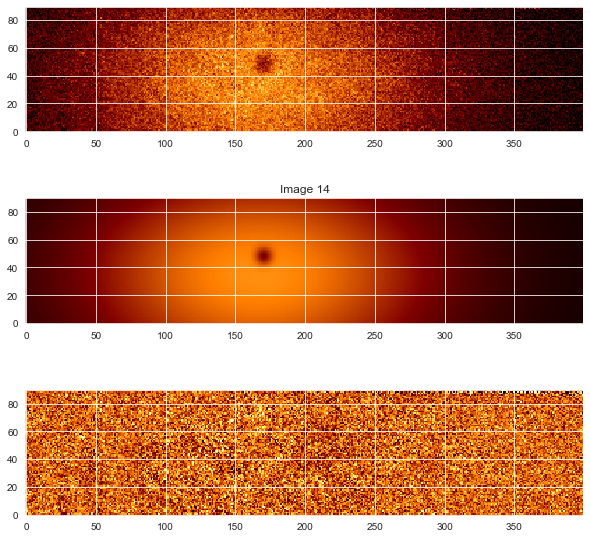

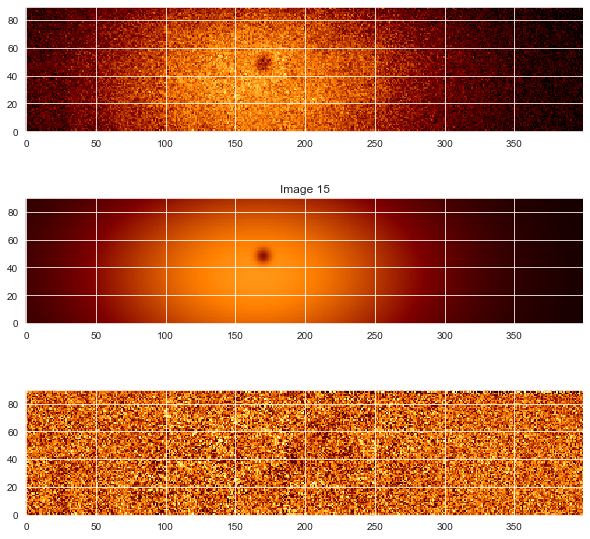

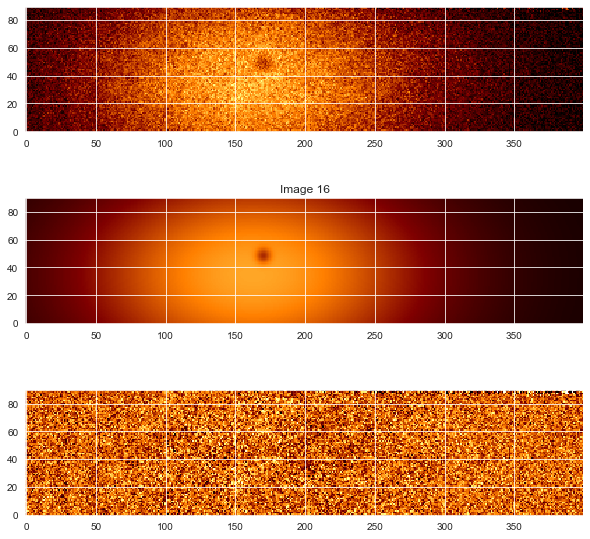

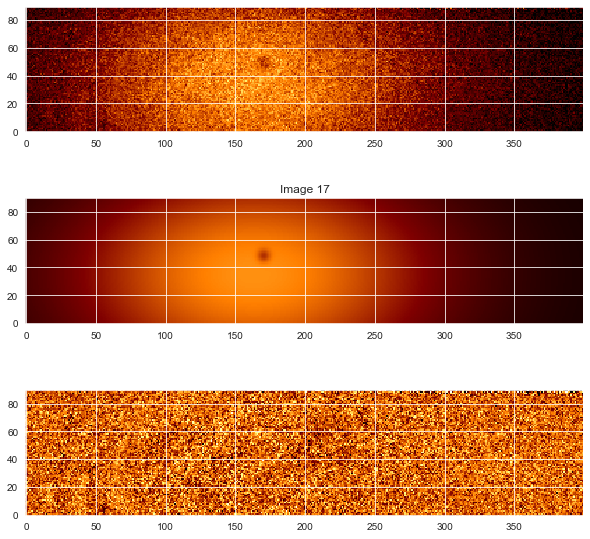

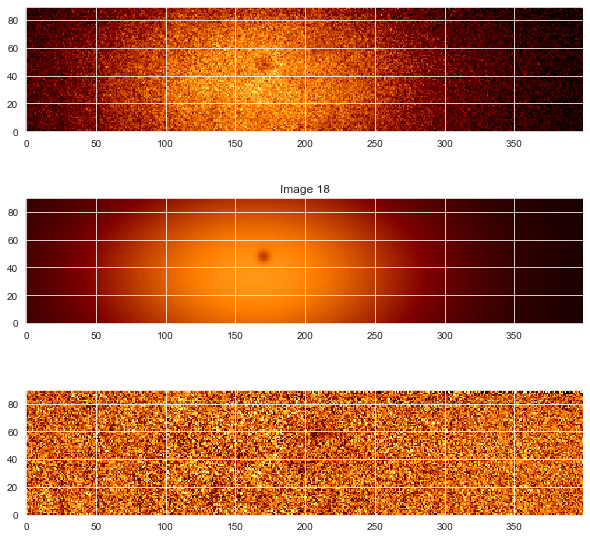

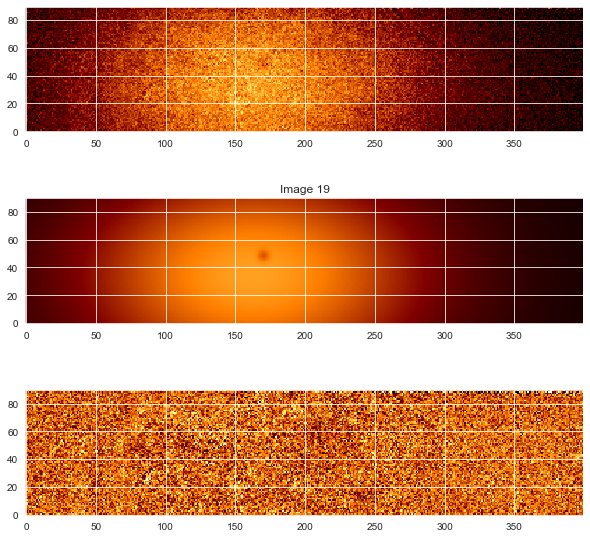

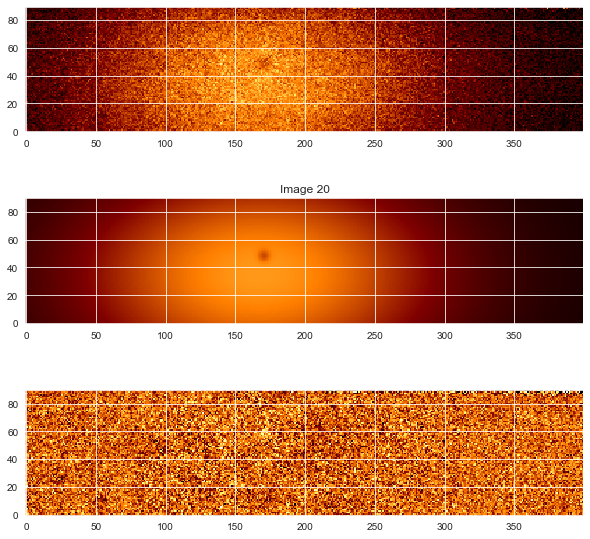

In [37]:
results=list()
for n in range(0,len(variables)):
    bg,std= make_background(N)
    image = fitsopen_bg(n,bg)
    #image =  gaussian_filter(image, 1, order=0, output=None, mode='constant', cval=0.0, truncate=4.0)
    shape = image.shape
    x,y = np.mgrid[0:shape[0],0:shape[1]]
    image_flat=image.flatten()    
    out = model.fit(image_flat,params,xy_mesh=(x,y))##method='Powel')
    fig,ax = plt.subplots(3,1,figsize=(10,10))
    results.append(copy.deepcopy(out))
    #params = out.params

    vmax = 1
    ax[0].imshow(image,
                 origin='bottom',vmin=0, vmax=vmax)
    ax[1].set_title('Image '+str(n))
    ax[1].imshow(out.best_fit.reshape(shape),
                 origin='bottom',vmin=0, vmax=vmax)
    ax[2].imshow((image-out.best_fit.reshape(shape)),
                 origin='bottom',vmin=-0.2, vmax=vmax/4)
    plt.show()

In [38]:

def AutlerTownesIm(Dp=0,Dp0=0,Dc=0,Dc0=0,g31=0.3,g21=0.1,Wc=0.5,y0=0.2,y1=0,offset=0):
    """
    Imaginary Part of the first order susceptibility
    
    in the ladder scheme:
    index 1 ~ ground state
    index 2 ~ Rydberg state
    index 3 ~ intermediate state
    
    
    """
    
    #Dp = Dp-Dp0
    Dc = Dc-Dc0
    d = Dp-Dc
    return offset+(y0+y1*Dp)*( 8*d**2 * g31 + 2*g21*(abs(Wc)**2 + g21*g31)) / abs(abs(Wc)**2 + (g31+1.j*2*Dp)*(g21+1.j*2*d))**2

model_AT = Model(AutlerTownesIm,independent_vars = ['Dc'])
params = model_AT.make_params()
#params.add('Dc',value=0.5)#,vary=False)
params.add('g31',value=6,min=2,max=10)
params.add('g21',value=0.06,min=0)
params.add('Wc',value=1,min=0)
params.add('y0',value=0.4)
params.add('y1',value=0,vary=False)
params.add('offset',value=0.15)
params.add('Dc0',value=0.00)
params.add('Dp0',value=0,vary=False)
params.add('Dp',value=0,vary=False)

In [39]:
model = LorentzianModel()+ConstantModel()
params = model.make_params()

In [40]:
def LZ(x,amplitude,W,x0,c):
    return amplitude*np.exp(2*np.pi*W**2/(x-x0))+c

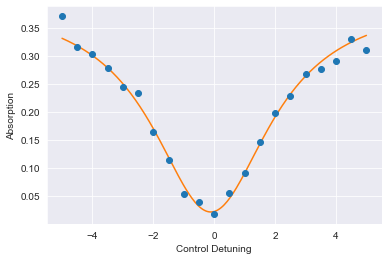

In [41]:
y = [1-np.e**(-r.params['amplitude2'].value-r.params['amplitude1'].value) for r in results]
#yerr = np.sqrt([ (r.params['amplitude2'].stderr/r.params['amplitude2'].value)**2+(r.params['amplitude1'].stderr/r.params['amplitude1'].value)**2 
#        if (r.params['amplitude2'].stderr is not None) & (r.params['amplitude2'].stderr is not None) else 0 for r in results ])

yerr = np.sqrt([ (r.params['amplitude2'].stderr)**2+(r.params['amplitude1'].stderr)**2 + (r.params['offset'].stderr)**2 if (r.params['amplitude2'].stderr is not None) & (r.params['amplitude2'].stderr is not None) & (r.params['offset'].stderr is not None) else 0 for r in results ])
#yerr=np.array(yerr)*y
plt.errorbar(variables,y,yerr=yerr,marker='o',linestyle='')

out = model.fit(y,params=params,x=variables )

v = np.linspace(min(variables),max(variables),200)

plt.plot(v,model.eval(out.params,x=v))

#y = [1-np.exp(-r.params['amplitude1'].value) for r in results]


plt.xlabel("Control Detuning")
plt.ylabel("Absorption")
plt.savefig("EIT-scanblue.svg")
plt.show()

In [42]:
%notebook -e analysis.ipynb

In [43]:
out

In [24]:
out.params.pretty_print()

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude      -2.5     -inf      inf   0.2547     True     None     None
c            0.3668     -inf      inf  0.01437     True     None     None
center      -0.5492     -inf      inf  0.05175     True     None     None
fwhm          4.524     -inf      inf   0.3471    False 2.0000000*sigma     None
height      -0.3518     -inf      inf  0.01356    False 0.3183099*amplitude/max(1.e-15, sigma)     None
sigma         2.262        0      inf   0.1736     True     None     None


### Fit amplitude 1

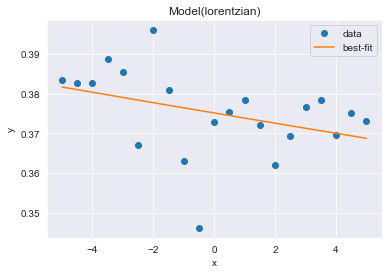

In [11]:
y = [1-np.exp(-r.params['amplitude1'].value) for r in results]

model = LorentzianModel()
lor_fit = model.fit(y,x=variables)
lor_fit.plot_fit()

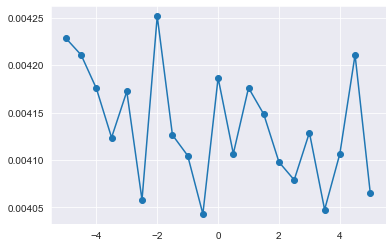

In [12]:
out.result
y = [ r.redchi for r in results]

plt.plot(variables,y,'o-')

#y = [ r. for r in results]

#plt.plot(variables,y,marker='o',linestyle='')

In [13]:
r = results[0]

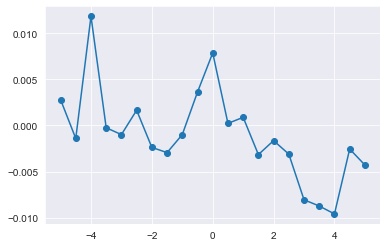

In [14]:
y = np.array([r.residual.reshape(shape)[40:60,160:180].mean() for r in results])
plt.plot(variables,1-np.exp(-y),'o-')


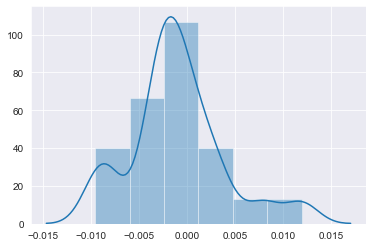

In [15]:
sns.distplot(y,bins=6)

In [21]:
fit

NameError: name 'fit' is not defined